# For processing UV-Vis spectroelectrochemistry data
### Rajiv Giridharagopal, rgiri@uw.edu

You can run this notebook by hitting **shift-click** on each cell (including this one!)

You will need to set the data_path below where it says "COPY_PATH_TO_FOLDER_HERE"  
> r'C:\Users\Raj\OneDrive\Documents\Word\uvvis'  

When you copy-paste, ONLY overwrite the part within quotes. Leave the r' ' intact  

In [10]:
import os
os.chdir(r'C:\Users\Raj\SkyDrive\UW Work\Coding and Signal Processing Work\Python\OECT')
import uvvis
import cv
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pickle

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 8)

### Set up Data paths and global processing variables

In [6]:
# 1) Set up the data path
# e.g. r'C:\Users\Raj\OneDrive\Documents\Word\uvvis'
data_path = r'C:\Users\Raj\SkyDrive\UW Work\Data\Polymer OECT work\DPP3TEG-1\uvvis\20191119\06 - CB 2-8 20 mgmL KCl (sample 02)\raw'

if data_path == 'COPY_PATH_TO_FOLDER_HERE':
    from oect_load import file_open
    data_path = file_open(caption='Select folder to load from')
    print('Loading from', data_path)
    # For the same of this demo notebook, I'll pull up some old data.
    # Comment out this line when you want to actually run this! Just type a # in front of the line
#data_path = r'C:\Users\Raj\OneDrive\UW Work\Data\DPP-DTT\_uvVis\20190306 - DPPDTT 28 20 mgmL\01 - 28 20 mg unwashed KPF6'

# 2) Select the wavelength for extracting kinetics, and the potential for plotting time-dependent spectra
wavelength = 500
potential = 0.7

# 3) For saving the figures, add a small string to the filename. e.g. "20190825". By default it's blank
filenamestring = ''

# 4) Save path. By default this will just be in the data path
path = data_path

In [7]:
# This block reads all the text files and saves them as a list of file paths for Python to read
#   Steps = the voltage steps. Not actually needed but it contains the current
#   Specs = spectra
#   Volts = potentials extracted from the steps files

steps, specs, volts, dedopesteps, dedopespecs = uvvis.read_files(data_path)

## 1. Process Data!

#### Here's what this block does:

First, we load the data as a uvvis object
> data = uvvis.uvvis(steps, specs, volts)

1) Now, we process the data by reading in all the spectra at each voltage.  
This step takes all the spectra and saves the time=0 s (initial) spectra at each voltage as a big matrix
It then extracts absorbance vs voltage at a specific wavelength. The command below is at 500 nm
> data.spec_echem_voltage(wavelength=500)

2) Then, we create a giant dictionary that contains a huge matrix of each time-dependent spectra  
> data.time_dep_spectra()

To access the 0.7 V, for example, you'd run this then type 
> data.spectra_vs_time[0.7]

3) Finally, we extract a single time-dependent kinetics trace. Edit the potential and wavelength (wl) based on your data. The command below plots the kinetics for the 0.7 V case and wavelength=500 nm:
> data.single_wl_time(wavelength = 500, potential = 0.7)

4) As an option, we can extract the current from the 'steps' files. This is not that critical
> data.current_vs_time()

Lastly, this saves the data as 2 ".PKL" (pickle) files, dopingdata.pkl and dedopingdata.pkl. It's ~120 MB as opposed to 2 GB, and contains all the data!

In [8]:
# Load Data

# Did you already load any data? If so, this avoids reprocessing. You can manually override this by changing to True
overwrite = False

if not overwrite:
    try:
        with open(path + r'\dopingdata.pkl', 'rb') as input:
            data = pickle.load(input)
        print('Loaded existing doping data')
        with open(path + r'\dedopingdata.pkl', 'rb') as input:
            data = pickle.load(input)
        print('Loaded existing dedoping data')
        print('If you REALLY want to reload all the data, change overwrite to True. You should not need to ever do this.')
    except:
        overwrite = True

if overwrite:
    ####### LOAD DATA ######
    data = uvvis.uv_vis(steps, specs, volts)

    # Actual processing of data. This takes a long time!!
    print('Processing data...hold on!')
    data.spec_echem_voltage(wavelength=wavelength)
    print('Generating spectra vs time')
    data.time_dep_spectra()
    print('Extracting single wavelength kinetics')
    data.single_wl_time(wavelength=wavelength, potential=potential)
    print('Current extraction')
    data.current_vs_time()
    print('Voltage extraction')
    data.abs_vs_voltage(wavelength, time=-1)
    
    with open(path + '\dopingdata.pkl', 'wb') as output:
    
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

    if any(dedopespecs):
        dedata = uvvis.uv_vis(dedopesteps, dedopespecs, volts)
        print('### Dedoping Data ###' )
        # Actual processing of data. This takes a long time!!
        print('Processing data...hold on!')
        dedata.spec_echem_voltage(wavelength=wavelength)
        print('Generating spectra vs time')
        dedata.time_dep_spectra()
        print('Extracting single wavelength kinetics')
        dedata.single_wl_time(wavelength=wavelength, potential=potential)
        print('Current extraction')
        dedata.current_vs_time()
        print('Voltage extraction')
        dedata.abs_vs_voltage(wavelength, time=-1)
        with open(path + '\dedopingdata.pkl', 'wb') as output:
    
            pickle.dump(dedata, output, pickle.HIGHEST_PROTOCOL)
    else:
        dedata = [] # flag for later

Processing data...hold on!
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Voltage extraction
### Dedoping Data ###
Processing data...hold on!
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Voltage extraction


In [12]:
filename = data_path+r'\doping'

with h5py.File(filename+'.h5', 'w') as f:
    dset = f.create_dataset('potentials', (len(data.potentials),))
    dset[:] = data.potentials[:]
f.close()

for p in data.spectra_vs_time:
    data.spectra_vs_time[p].to_hdf(filename+'.h5', key=str(p), mode='a')

filename = data_path+r'\dedoping'    
    
with h5py.File(filename+'.h5', 'w') as f:
    dset = f.create_dataset('potentials', (len(dedata.potentials),))
    dset[:] = dedata.potentials[:]
f.close()

for p in dedata.spectra_vs_time:
    dedata.spectra_vs_time[p].to_hdf(filename+'.h5', key=str(p), mode='a')

## 2. Cool Plots!

### First, simple spectra vs voltage

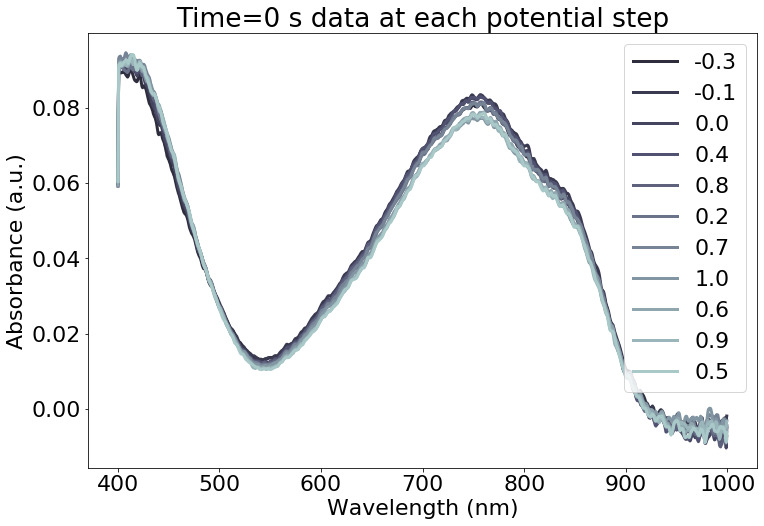

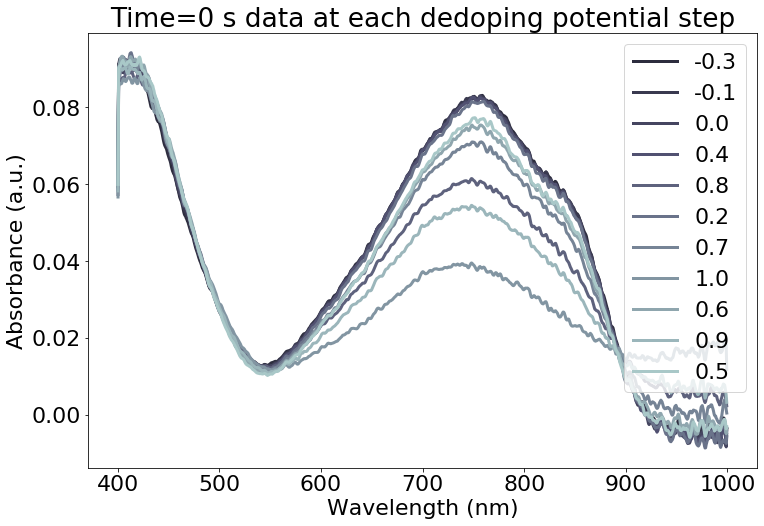

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
plt.rcParams.update({'font.size': 22})

# This block just generates a cool colormap
# In the last line, you can replace "bone" with any colormap name from here: 
#     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
for i,cl in zip(data.spectra_sm, cm):
    ax.plot(data.spectra_sm[i], linewidth=3,
           color=plt.cm.bone(cl))  

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.legend(labels = data.potentials)
ax.set_title('Time=0 s data at each potential step')

plt.savefig(path + r'\\' + 'Doping Spectra, t=0 s'+filenamestring+'.jpg')

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
    plt.rcParams.update({'font.size': 22})

    # This block just generates a cool colormap
    # In the last line, you can replace "bone" with any colormap name from here: 
    #     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
    for i,cl in zip(dedata.spectra_sm, cm):
        ax.plot(dedata.spectra_sm[i], linewidth=3,
               color=plt.cm.bone(cl))  

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.legend(labels = dedata.potentials)
    ax.set_title('Time=0 s data at each dedoping potential step')

    plt.savefig(path + r'\\' + 'Dedoping Spectra, t=0 s'+filenamestring+'.jpg')


### Now, let's plot spectra vs time for a particular voltage.
##### Change this line
> potential = 0.7 
##### to whatever voltage you want to plot the kinetics of

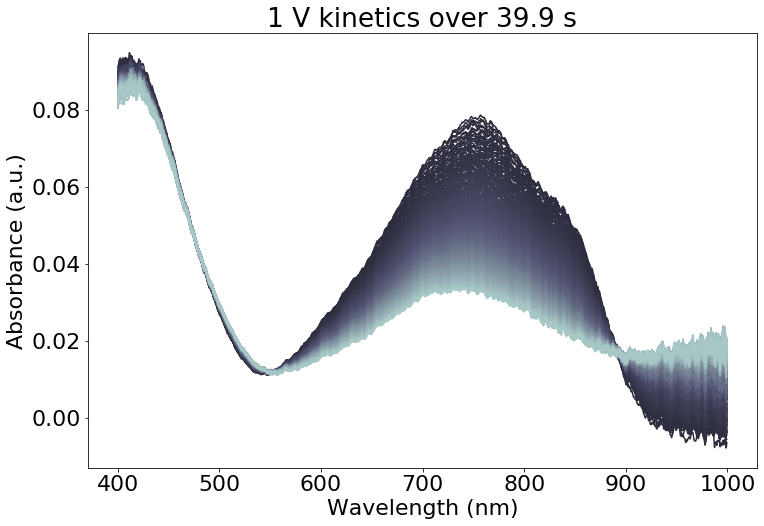

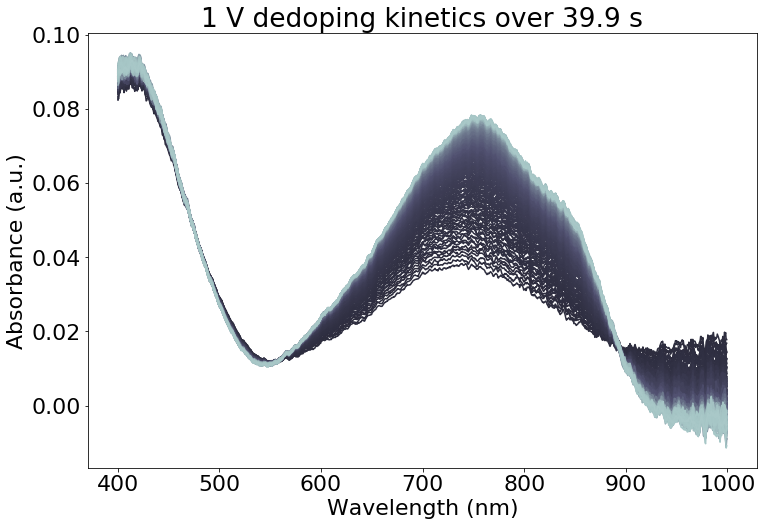

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

potential = 1 # Change this to whatever voltage you want to plot

endtime = data.spectra_vs_time[potential].columns[-1]
cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
for i,cl in zip(data.spectra_vs_time[potential], cm):
    ax.plot(data.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.set_title(str(potential) +' V kinetics over ' + str(endtime) + ' s')

plt.savefig(path + r'\\' + 'Kinetics at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

    #potential = 0.7 # Change this to whatever voltage you want to plot

    endtime = dedata.spectra_vs_time[potential].columns[-1]
    cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
    for i,cl in zip(dedata.spectra_vs_time[potential], cm):
        ax.plot(dedata.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.set_title(str(potential) +' V dedoping kinetics over ' + str(endtime) + ' s')

    plt.savefig(path + r'\\' + 'Dedoping Kinetics at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')


### Plot the kinetics at a particular wavelength and voltage

##### Change these lines
> potential = 0.7  
> wavelength = 800  
##### to whatever voltage and wavelength you want

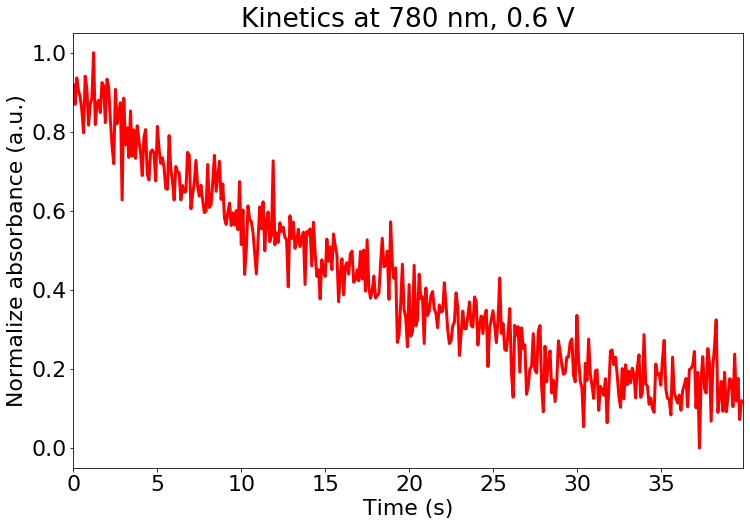

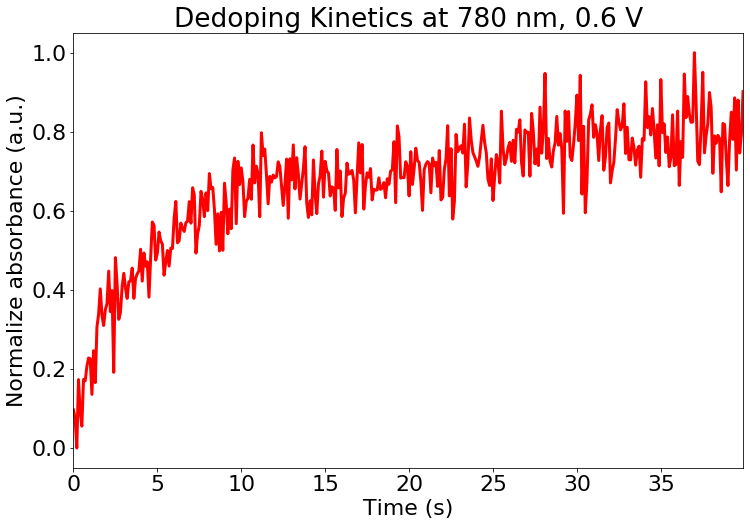

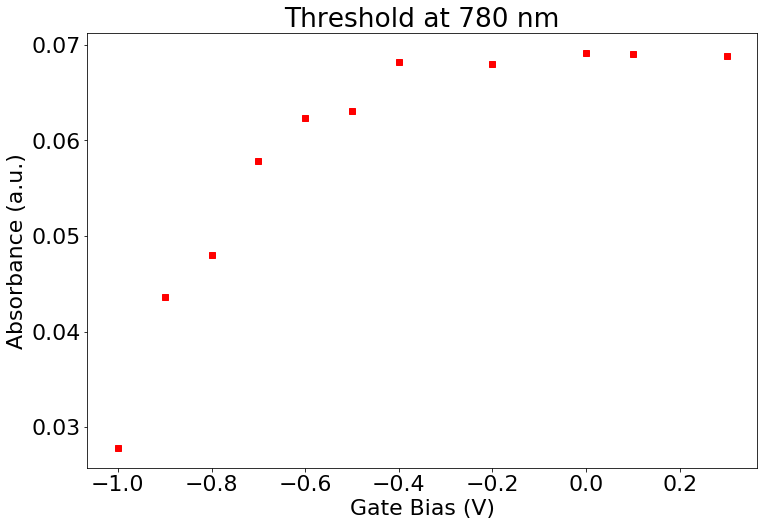

In [25]:
# Changes these two lines to whatever potential and wavelength you want
potential = 0.6
wavelength = 780

data.single_wl_time(potential=potential, wavelength = wavelength)
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_time(data, ax=ax, **{'color':'r', 'linewidth': 3})
ax.set_title('Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

plt.savefig(path + r'\\' + 'Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
            +filenamestring+'.jpg')

if dedata:
    dedata.single_wl_time(potential=potential, wavelength = wavelength)
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
    uvvis.plot_time(dedata, ax=ax, **{'color':'r', 'linewidth': 3})
    ax.set_title('Dedoping Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

    plt.savefig(path + r'\\' + 'Dedope Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
                +filenamestring+'.jpg')
    
fig, ax1 = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_voltage(data, ax=ax1, **{'color':'r', 'linewidth': 3, 'marker':'s', 'linewidth':0})
ax1.set_title('Threshold at ' + str(wavelength) + ' nm')

plt.savefig(path + r'\\' + 'Threshold at ' + str(wavelength) + ' nm'
            +filenamestring+'.jpg')

### Plot the kinetics as a rad-looking spectrogram

#### These data are not actually any different from the above kinetics data

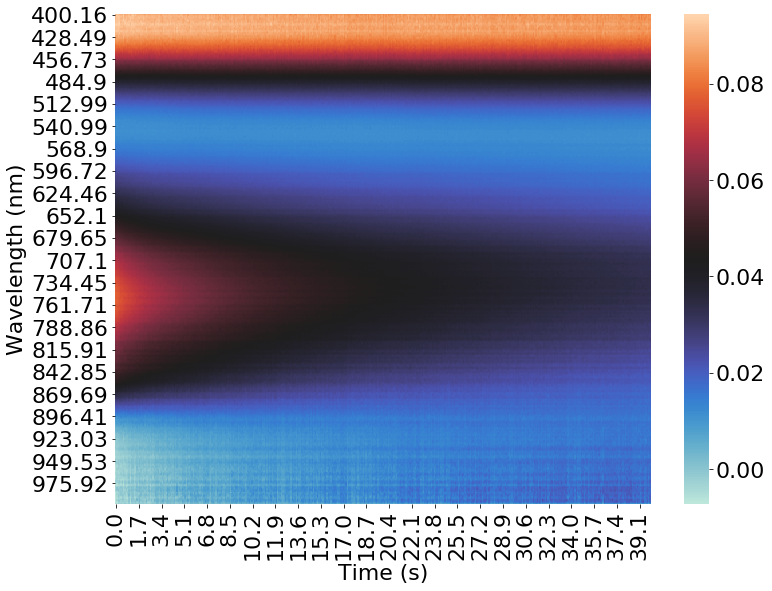

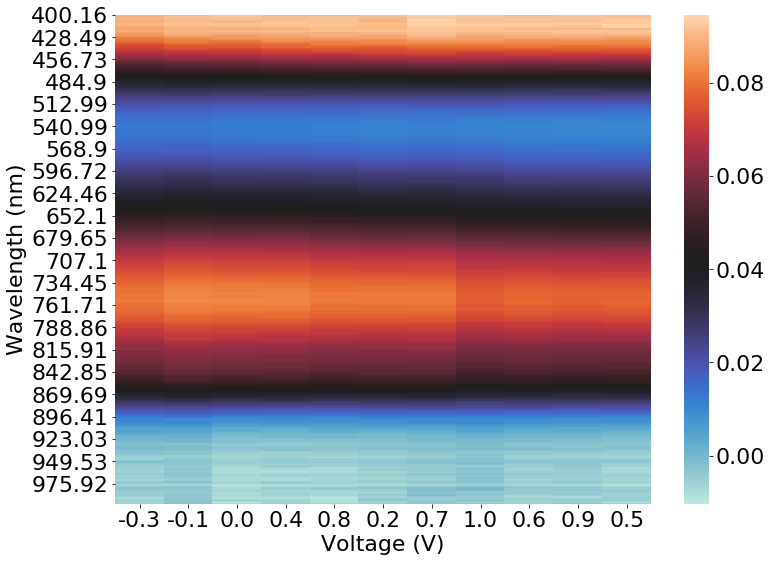

In [29]:
# Change potential to whatever voltage you want
# change cmap only if you know what that means
potential = 1
kwargs = {}
kwargs['cmap'] = 'icefire'

# Sets up two dataframes for plotting
import pandas as pd
import seaborn as sns
wl = np.round(data.spectra_vs_time[potential].index.values, 2)
df = pd.DataFrame.copy(data.spectra_vs_time[potential])
df = df.set_index(wl)
dfv = pd.DataFrame.copy(data.spectra_sm)
dfv = dfv.set_index(wl)

# spectra vs time
fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(df,ax=ax0, **kwargs)    
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Wavelength (nm)')
plt.savefig(path + r'\\' + 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')

# spectra vs voltage
fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(dfv,ax=ax1, **kwargs)    
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Wavelength (nm)')

plt.savefig(path + r'\\' + 'Spectrogram at t = 0 s'
            +filenamestring+'.jpg')

In [ ]:
if dedata:
        # Change potential to whatever voltage you want
    # change cmap only if you know what that means
    #potential = 0.7
    kwargs = {}
    kwargs['cmap'] = 'icefire'

    # Sets up two dataframes for plotting
    import pandas as pd
    import seaborn as sns
    wl = np.round(dedata.spectra_vs_time[potential].index.values, 2)
    df = pd.DataFrame.copy(dedata.spectra_vs_time[potential])
    df = df.set_index(wl)
    dfv = pd.DataFrame.copy(dedata.spectra_sm)
    dfv = dfv.set_index(wl)

    # spectra vs time
    fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(df,ax=ax0, **kwargs)    
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Wavelength (nm)')
    plt.savefig(path + r'\\' + 'Dedoping Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')

    # spectra vs voltage
    fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(dfv,ax=ax1, **kwargs)    
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Wavelength (nm)')

    plt.savefig(path + r'\\' + 'Dedoping Spectrogram at t = 0 s'
                +filenamestring+'.jpg')

## 3. A brief tour through what this all contains for your reference

## (This part is not necessary to run)

In [18]:
# data.spectra -- the data as one large dataframe vs voltage
data.spectra

,-0.3,0.0,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Wavelength (nm),,,,,,,,,,
400.159241,0.049652,0.045639,0.042481,0.046800,0.048003,0.049015,0.041306,0.035615,0.032342,0.033217
400.750183,0.036503,0.049374,0.046992,0.043492,0.046918,0.041484,0.033554,0.029174,0.027704,0.033027
401.341095,0.036508,0.043282,0.037895,0.039518,0.037412,0.038089,0.048835,0.034885,0.024662,0.033244
401.931976,0.040653,0.043872,0.046822,0.040257,0.037124,0.039573,0.036576,0.028045,0.028828,0.032408
402.522797,0.045172,0.042812,0.036591,0.043942,0.035008,0.038595,0.039917,0.033913,0.026219,0.030994
403.113586,0.037670,0.046455,0.037131,0.036311,0.033582,0.041774,0.037166,0.032931,0.024367,0.021215
403.704407,0.040266,0.040841,0.038894,0.042502,0.041428,0.039029,0.042343,0.034559,0.029663,0.031083
404.295105,0.039227,0.043046,0.043974,0.036692,0.035362,0.040636,0.038671,0.033566,0.024026,0.025585
404.885834,0.039787,0.033263,0.038039,0.040774,0.042924,0.040186,0.035134,0.025439,0.022138,0.027579


In [19]:
# All the spectra vs time
data.spectra_vs_time

{-0.3:                      0.0       0.1       0.2       0.3       0.4       0.5   \
 Wavelength (nm)                                                               
 400.159241      -0.071208  0.005380  0.033230  0.044378  0.050511  0.039663   
 400.750183      -0.068946  0.005824  0.029495  0.035406  0.035876  0.043811   
 401.341095      -0.068242  0.004643  0.028417  0.035509  0.035497  0.040307   
 401.931976      -0.069084  0.000975  0.025695  0.034534  0.034748  0.035305   
 402.522797      -0.061938  0.004033  0.028733  0.037029  0.040275  0.039762   
 403.113586      -0.069043 -0.001064  0.023321  0.038551  0.033047  0.040106   
 403.704407      -0.064920  0.005423  0.030455  0.038928  0.043624  0.036130   
 404.295105      -0.065253  0.004587  0.024157  0.033633  0.044043  0.047488   
 404.885834      -0.055353  0.005046  0.024133  0.040097  0.040374  0.039244   
 405.476532      -0.063662 -0.000909  0.024611  0.027951  0.031621  0.029700   
 406.067139      -0.054003  0.0072

In [22]:
data.time_spectra_norm # normalized time-dependent spectra

0.0     0.000000
0.1     0.683973
0.2     0.822983
0.3     0.753919
0.4     0.790770
0.5     0.822691
0.6     0.914968
0.7     0.862177
0.8     0.836287
0.9     0.870079
1.0     0.916507
1.1     0.864957
1.2     0.891894
1.3     0.789529
1.4     0.867445
1.5     0.873812
1.6     0.959842
1.7     0.777047
1.8     0.951626
1.9     0.850180
2.0     0.955587
2.1     0.846523
2.2     0.907495
2.3     0.819695
2.4     0.922590
2.5     0.930360
2.6     0.741741
2.7     0.934832
2.8     0.868543
2.9     0.754721
          ...   
17.0    0.901268
17.1    0.937618
17.2    0.748376
17.3    0.996474
17.4    0.889917
17.5    0.900463
17.6    0.820206
17.7    0.916727
17.8    0.871250
17.9    0.913503
18.0    0.854496
18.1    0.910059
18.2    0.888379
18.3    0.911451
18.4    0.949572
18.5    0.732337
18.6    0.871324
18.7    0.775587
18.8    0.828977
18.9    0.767195
19.0    0.938791
19.1    0.733795
19.2    0.728547
19.3    0.935052
19.4    0.906396
19.5    0.913356
19.6    0.833655
19.7    0.9439

In [23]:
data.time_spectra # un-normalized time-dependent spectra

0.0     0.015980
0.1     0.023322
0.2     0.025460
0.3     0.026554
0.4     0.026324
0.5     0.026084
0.6     0.026638
0.7     0.026097
0.8     0.025708
0.9     0.026704
1.0     0.026801
1.1     0.026511
1.2     0.026439
1.3     0.025598
1.4     0.026929
1.5     0.026199
1.6     0.027802
1.7     0.026624
1.8     0.026343
1.9     0.027245
2.0     0.027033
2.1     0.026457
2.2     0.026650
2.3     0.026996
2.4     0.026443
2.5     0.027048
2.6     0.026212
2.7     0.027048
2.8     0.026051
2.9     0.026002
          ...   
17.0    0.027048
17.1    0.027133
17.2    0.026445
17.3    0.027482
17.4    0.026845
17.5    0.026612
17.6    0.026598
17.7    0.027321
17.8    0.026811
17.9    0.026957
18.0    0.026611
18.1    0.026779
18.2    0.026925
18.3    0.027026
18.4    0.026864
18.5    0.026891
18.6    0.026659
18.7    0.026353
18.8    0.026716
18.9    0.025872
19.0    0.027293
19.1    0.026264
19.2    0.026294
19.3    0.026936
19.4    0.026627
19.5    0.026715
19.6    0.026790
19.7    0.0271